# points

> binomial and poisson point process

In [ ]:
#| hide
#| default_exp points

In [ ]:
#| hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [ ]:
#| export
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import functools
import collections
from fastcore.basics import patch
from typing import Literal, Optional

In [ ]:
#|export

class Points:
    """generate binomial or poisson points in a convex set, default to unit box"""
    def __init__(self, n,d=2, seed=None, law: Literal["binomial","poisson"]="binomial", shape:Optional[ConvexHull]=None):
        assert law in ["binomial","poisson"]
        self.n = np.random.default_rng(seed).poisson(n) if law == "poisson" else n
        self.d = d
        self.shape = shape
        self.seed = seed
    
    @functools.cached_property
    def points(self):
        if self.shape is None:
            return np.random.default_rng(self.seed).uniform(size=(self.n,self.d))
        else:
            ps = []
            for _ in range(self.n):
                while True:
                    sample = np.random.default_rng().uniform(size=(self.d,))
                    if in_hull(sample, self.shape): 
                        ps.append(sample); break
            assert len(ps)==self.n
            return np.array(ps)


In [ ]:
#|export

def in_hull(point,hull:ConvexHull,tol=1e-9):
    assert len(point)==hull.ndim, "expect point, hull in the same dimension"
    W,b = hull.equations[:,:-1], hull.equations[:,-1]
    return np.all(W@point+b<=tol)

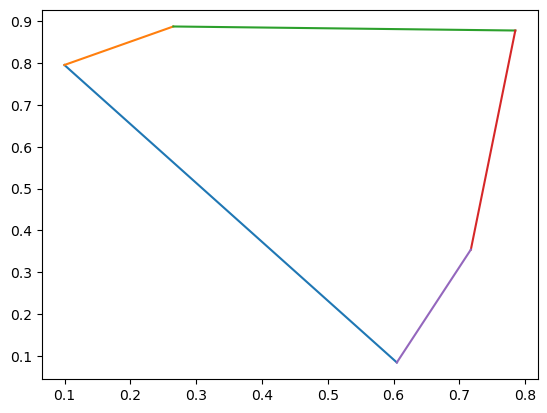

In [ ]:
vertices = np.random.default_rng().uniform(size=(5,2))
hull = ConvexHull(vertices)
for s in hull.simplices:
    plt.plot(vertices[s,0], vertices[s,1])

True


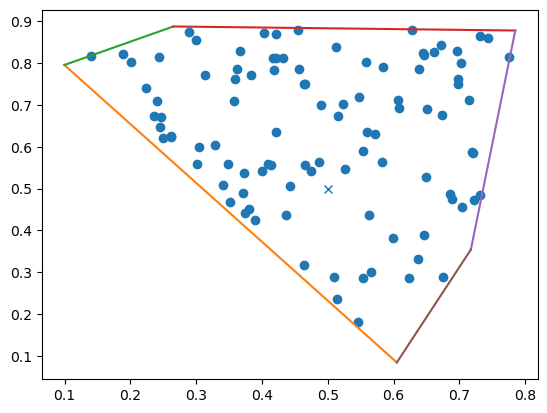

In [ ]:

bin = Points(100,shape=hull).points
p = np.array([0.5,0.5])
print(in_hull(p, hull))
plt.scatter(*bin.T)
plt.plot(*p, 'x')
for s in hull.simplices:
    plt.plot(vertices[s,0], vertices[s,1])

In [ ]:
Points(10,d=3,shape=ConvexHull(np.random.default_rng().uniform(size=(4,3)))).points

array([[0.35496566, 0.38394623, 0.41984606],
       [0.21961072, 0.39056185, 0.41219703],
       [0.37981872, 0.28310479, 0.33563207],
       [0.40665716, 0.57985185, 0.62529978],
       [0.17322054, 0.2894313 , 0.33036923],
       [0.26265738, 0.66562088, 0.63119486],
       [0.47784195, 0.27761133, 0.39794601],
       [0.21518766, 0.35028744, 0.29313638],
       [0.35761217, 0.30372978, 0.35042544],
       [0.3172512 , 0.68104943, 0.66206126]])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()